# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Modèle de référence](#ref)
* [3. Augmentation des données](#data_augmentation)
  * [3.1 Augmentations manuelles #1](#data_augmentation_1)
  * [3.2 Augmentations manuelles #2](#data_augmentation_2)
  * [3.3 Augmentations automatique #1](#data_augmentation_auto_1)
* [4. Recherche d'une meilleure fonction de perte](#loss)
* [5. Recherche d'une meilleur architecture](#archi)
  * [4.1 `U-Net` custom](#archi1)
  * [4.2 `U-Net` based on resnet101 + imagenet](#archi2)
  * [4.3 `FPN` based on elasticnet + imagenet](#archi3)
  * [4.4 `SegFormer`](#archi4)
  * [4.5 Vision Transformer (ViT)](#archi5)

---
---
# 1. Préparatifs pour de la classification avec des Transformers <a class="anchor" id="init"></a> [⇪](#menu)

In [2]:
import time
import glob
import math
import pathlib
import datetime

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from keras import layers

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a0f5e361-f074-1641-5cbd-64aed1bb3234)


## Fonctions communes

In [7]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title(f_loss.name.title())
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot metric
    plt.subplot(212)
    plt.title('IoU scores')
    plt.plot(history.history['iou_score'], color='blue', label='train')
    plt.plot(history.history['val_iou_score'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)
    plt.show()

In [8]:
def compare_segmentations(img_source, mask_source, predictions):
    
    mask = np.argmax(predictions, axis=3)[0]
    
    fig = plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(img_source)
    plt.axis('off')
    plt.title("Source")

    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.axis('off')
    plt.title("Predicted mask")

    plt.subplot(1,3,3)
    plt.imshow(mask_source)
    plt.axis('off')
    plt.title("Original mask")
    
    plt.tight_layout()
    plt.show()

In [38]:
class Scores():
    
    def __init__(self, cols, save_path=None, load_path=None):
        self.cols = cols
        self.save_path = save_path
        
        if load_path and pathlib.Path.exists(load_path):
            self.scores = pd.read_csv(load_path, index_col=0)
        else:
            self.clear_scores()
        
    def add_scores(self, name, dict_scores):
        self.scores.loc[name] = dict_scores
        self.save_scores()
        
    def show_scores(self, name=None):
        if name:
            display(self.scores.loc[name])
        else:
            display(self.scores)
            
    def save_scores(self):
        if self.save_path:
            self.scores.to_csv(self.save_path)
            
    def clear_scores(self):
        self.scores = pd.DataFrame([], columns=self.cols)
        self.save_scores()
        
scorer = Scores(
    ['IoU', 'Dice', 'training_time', 'inference_time_500', 'inference_time_1'],
    pathlib.Path('logs', 'scores.csv'),
    pathlib.Path('logs', 'scores.csv'),
)

In [39]:
scorer.show_scores()

,IoU,Dice,training_time,inference_time_500,inference_time_1
U-Net_baseline,0.552171,0.667224,517.575655,1.851263,0.895139
U-Net_baseline_with_data_augmentation_1,0.564558,0.680571,1029.694759,2.369722,0.423762
U-Net_baseline_with_data_augmentation_2,0.559365,0.674603,714.297488,2.345822,0.924520
U-Net_baseline_with_data_augmentation_3,0.117844,0.197346,284.685457,2.193978,0.414083
U-Net_baseline_with_data_augmentation_2_diceLoss,0.631681,0.743959,843.582155,2.138717,0.903396


### DataGenerator

In [15]:
class CustomDataGenerator(keras.utils.Sequence):
    # We use Sequence as parent class, because Sequence are a safer way to do multiprocessing.
    # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
    
    def __init__(self, datapath, batch_size, augmentation=None, preprocessing=None, shuffle=False, verbose=0, maxbatches=None, *args, **kwargs):
        self.batch_size = batch_size
        self.ids = [x[:-4] for x in glob.glob(f"{datapath}/*[!_labels].png")]
        self.shuffle = shuffle
        self.verbose = verbose
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.maxbatches = maxbatches
        #print(len(self.ids), self.ids)
        
    def __len__(self):
        # returns the number of batches
        if self.maxbatches:
            return min(self.maxbatches, math.ceil(len(self.ids) / self.batch_size))
        else:
            return math.ceil(len(self.ids) / self.batch_size)
    
    def __getitem__(self, index):
        # returns one batch
        
        since = index * self.batch_size
        until = (index+1) * self.batch_size
        batch_ids = self.ids[since:until]
        
        images = []
        labels = []
        for source_id in batch_ids:
            if self.verbose > 0:
                print(source_id)
            
            x = np.array(Image.open(f"{source_id}.png"))            
            y = np.array(Image.open(f"{source_id}_labels.png"))
            
            if self.augmentation:
                augmented = self.augmentation(image=x, mask=y)
                x, y = augmented['image'], augmented['mask']
                
            if self.preprocessing:
                x = self.preprocessing(x)
              
            images.append(x/255.0) # normalize between 0 and 1 at the same time
            #labels.append(y)
            labels.append(keras.utils.to_categorical(y, 8))
         
        return np.array(images, dtype=float), np.array(labels, dtype=float)
        
    def on_epoch_end(self):
        # logics run once at the very beginning and then at the end of each epoch
        if self.shuffle:
            return np.random.shuffle(self.ids) # /!\ Is this really a good idea ????

### Callbacks

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")
    checkpoint = ModelCheckpoint(
        monitor="val_iou_score",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )
    
    # Define TensorBoard logging
    log_dir = f"logs/fit/{model_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
    tensorboard = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
    )
    
    # Define Learning-Rate modification conditions
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        # min_lr=0.001,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=9,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es, reduce_lr, tensorboard]

---
---
# 2. Modèle de référence *(baseline)* <a class="anchor" id="ref"></a> [⇪](#menu)

### Préparons les training et validation sets **sans** data-augmentation

In [17]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=None, # Pas d'augementations pour la baseline
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons notre modèle de référence

In [18]:
# From https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_model_ref(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [17]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [19]:
model_name = "U-Net_baseline"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.6805 - iou_score: 0.3965 - f1-score: 0.5185
Epoch 1: val_iou_score improved from -inf to 0.11330, saving model to models/U-Net_baseline.keras
372/372 [==============================] - 31s 82ms/step - loss: 0.6805 - iou_score: 0.3965 - f1-score: 0.5185 - val_loss: 1.7338 - val_iou_score: 0.1133 - val_f1-score: 0.1829 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.5258 - iou_score: 0.4529 - f1-score: 0.5748
Epoch 2: val_iou_score improved from 0.11330 to 0.42145, saving model to models/U-Net_baseline.keras
372/372 [==============================] - 28s 76ms/step - loss: 0.5258 - iou_score: 0.4529 - f1-score: 0.5748 - val_loss: 0.6314 - val_iou_score: 0.4215 - val_f1-score: 0.5444 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.4797 - iou_score: 0.4760 - f1-score: 0.5969
Epoch 3: val_iou_score improved from 0.42145 to 0.43063, savin

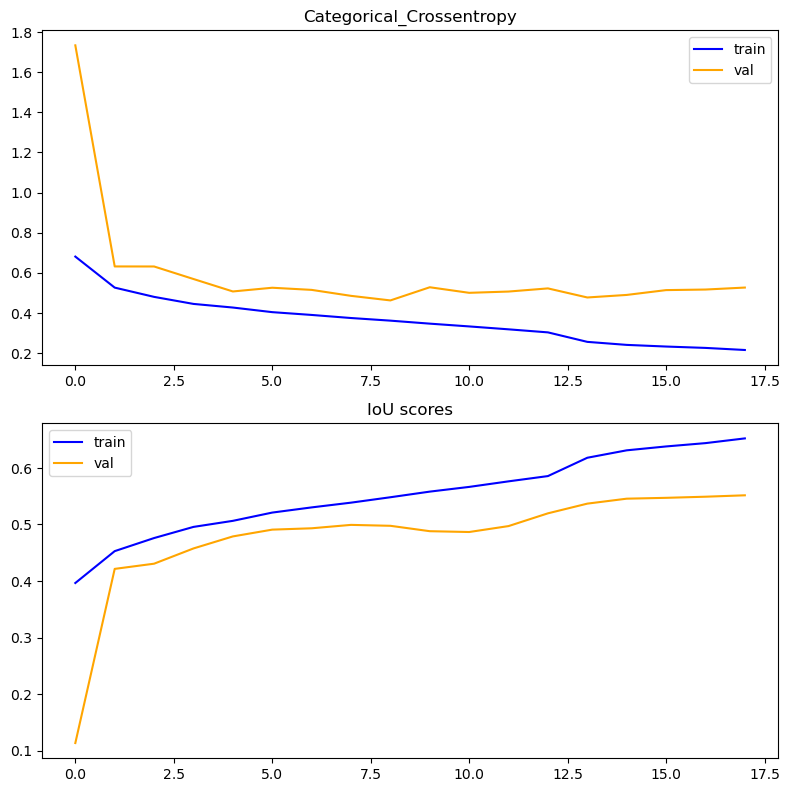

In [20]:
summarize_diagnostics(history)

In [22]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [24]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 28ms/step - loss: 0.5261 - iou_score: 0.5522 - f1-score: 0.6672
inference time (500 samples): 1.85s


### Test de prédiction

In [25]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [26]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 867ms/step
Inference time: 0.90s


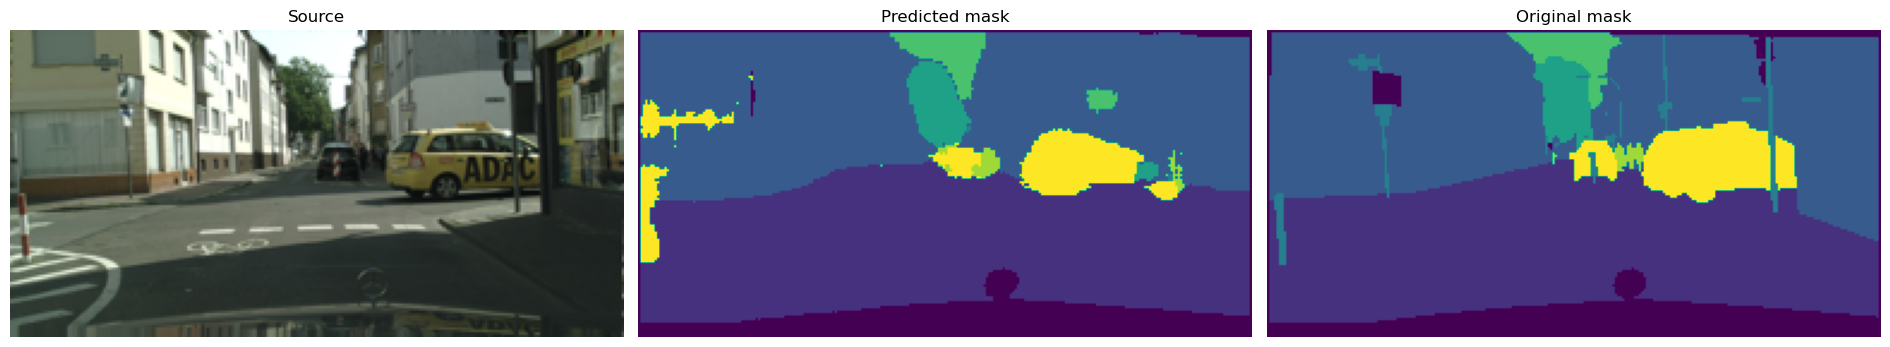

In [27]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [30]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [31]:
scorer.show_scores()

,IoU,Dice,training_time,inference_time_500,inference_time_1
U-Net_baseline,0.552171,0.667224,517.575655,1.851263,0.895139


---
---
# 3. Augmentation des données <a class="anchor" id="data_augmentation"></a> [⇪](#menu)

## 3.1 Augmentations manuelles #1 <a class="anchor" id="data_augmentation_1"></a> [⇪](#menu)
Pour cette première approche, je vais essayer des combinaisons de transformations qui me semblent logiques

### Préparons les training et validation sets **avec** data-augmentation

In [32]:
transform1 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # A.RandomCrop(width=100, height=100),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Transpose(p=0.5),
    # A.Blur(p=0.01, blur_limit = 3),
    # A.OneOf([
    #        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #        A.GridDistortion(p=0.5),
    #        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    # ], p=0.5)
])

In [33]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform1,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [35]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [36]:
model_name = "U-Net_baseline_with_data_augmentation_1"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.8646 - iou_score: 0.3436 - f1-score: 0.4652
Epoch 1: val_iou_score improved from -inf to 0.05546, saving model to models/U-Net_baseline_with_data_augmentation_1.keras
372/372 [==============================] - 31s 77ms/step - loss: 0.8646 - iou_score: 0.3436 - f1-score: 0.4652 - val_loss: 2.7226 - val_iou_score: 0.0555 - val_f1-score: 0.0984 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.6252 - iou_score: 0.3963 - f1-score: 0.5210
Epoch 2: val_iou_score improved from 0.05546 to 0.39194, saving model to models/U-Net_baseline_with_data_augmentation_1.keras
372/372 [==============================] - 28s 76ms/step - loss: 0.6252 - iou_score: 0.3963 - f1-score: 0.5210 - val_loss: 0.6193 - val_iou_score: 0.3919 - val_f1-score: 0.5159 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.5772 - iou_score: 0.4189 - f1-score: 0.5440
Epoch 3: val

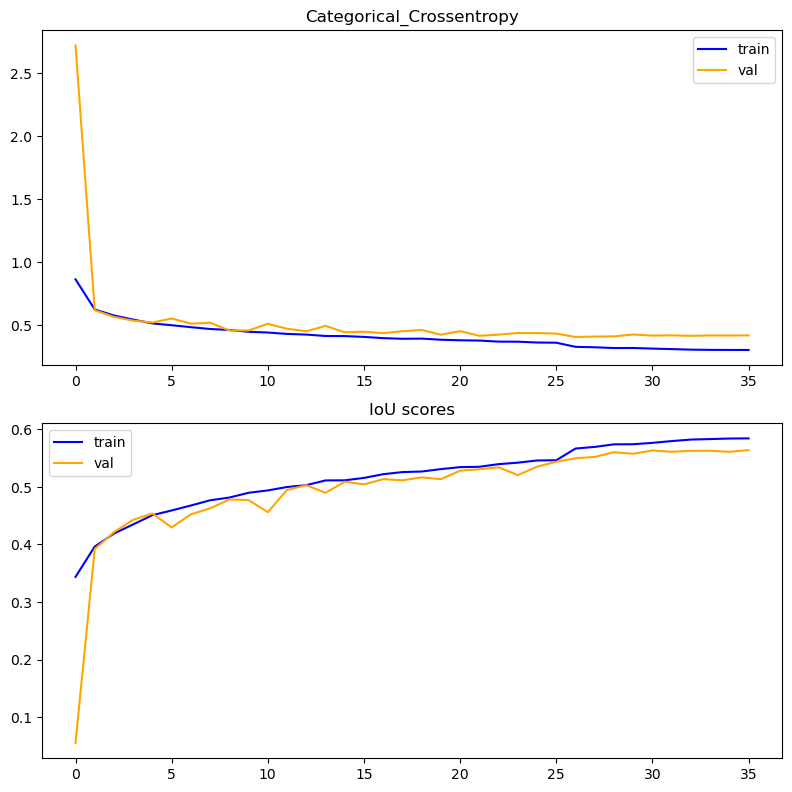

In [37]:
summarize_diagnostics(history)

In [38]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [39]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 28ms/step - loss: 0.4195 - iou_score: 0.5646 - f1-score: 0.6806
inference time (500 samples): 2.37s


### Test de prédiction

In [40]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [41]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 397ms/step
Inference time: 0.42s


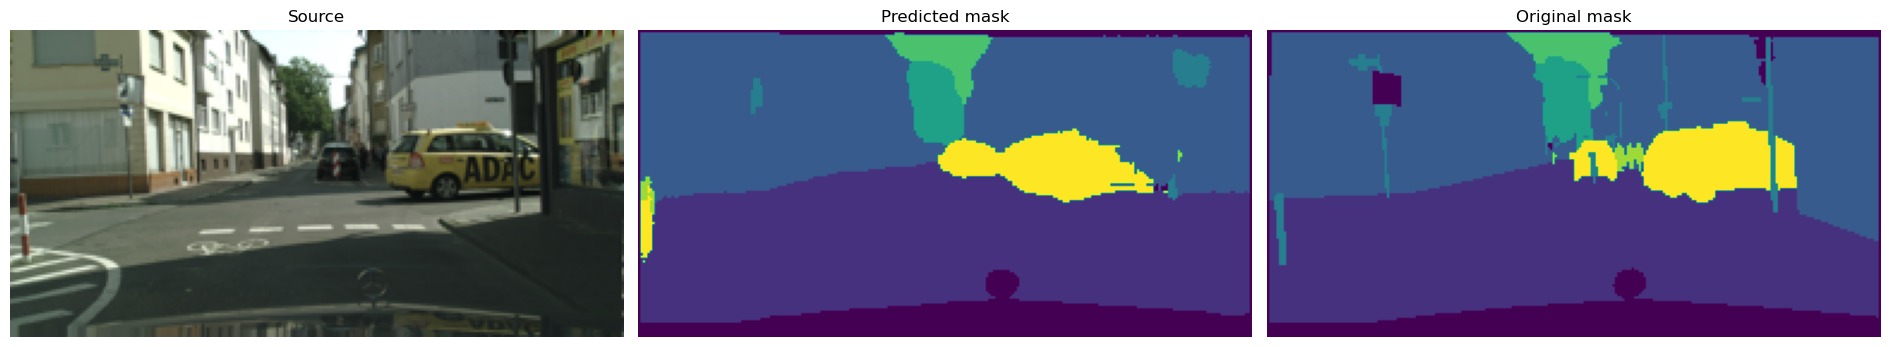

In [42]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [43]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [44]:
scorer.show_scores()

,IoU,Dice,training_time,inference_time_500,inference_time_1
U-Net_baseline,0.552171,0.667224,517.575655,1.851263,0.895139
U-Net_baseline_with_data_augmentation_1,0.564558,0.680571,1029.694759,2.369722,0.423762


## 3.2 Augmentations manuelles #2 <a class="anchor" id="data_augmentation_2"></a> [⇪](#menu)

Pour cette seconde approche, je vais essayer une autre combinaisons de transformations *(suggérées par mon mentor)*

### Préparons les training et validation sets **avec** data-augmentation

In [20]:
transform2 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=[-0.2, 0.2],
            contrast_limit=0.2,
            p=0.5,
        ),
        A.RandomGamma(p=0.5),
    ],
    p=0.8,
    ),
])

In [46]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [47]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [48]:
model_name = "U-Net_baseline_with_data_augmentation_2"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.8277 - iou_score: 0.3684 - f1-score: 0.4890
Epoch 1: val_iou_score improved from -inf to 0.07239, saving model to models/U-Net_baseline_with_data_augmentation_2.keras
372/372 [==============================] - 31s 77ms/step - loss: 0.8277 - iou_score: 0.3684 - f1-score: 0.4890 - val_loss: 2.2821 - val_iou_score: 0.0724 - val_f1-score: 0.1242 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.5672 - iou_score: 0.4301 - f1-score: 0.5536
Epoch 2: val_iou_score improved from 0.07239 to 0.39251, saving model to models/U-Net_baseline_with_data_augmentation_2.keras
372/372 [==============================] - 28s 76ms/step - loss: 0.5672 - iou_score: 0.4301 - f1-score: 0.5536 - val_loss: 0.6710 - val_iou_score: 0.3925 - val_f1-score: 0.5170 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.5173 - iou_score: 0.4549 - f1-score: 0.5775
Epoch 3: val

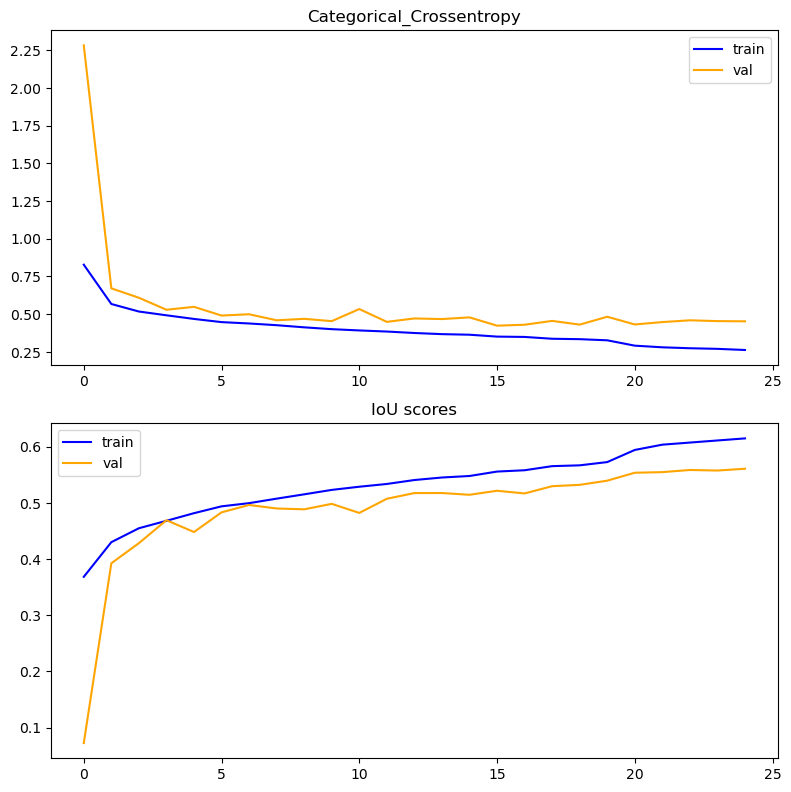

In [49]:
summarize_diagnostics(history)

In [50]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [51]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 28ms/step - loss: 0.4524 - iou_score: 0.5594 - f1-score: 0.6746
inference time (500 samples): 2.35s


### Test de prédiction

In [52]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [53]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 897ms/step
Inference time: 0.92s


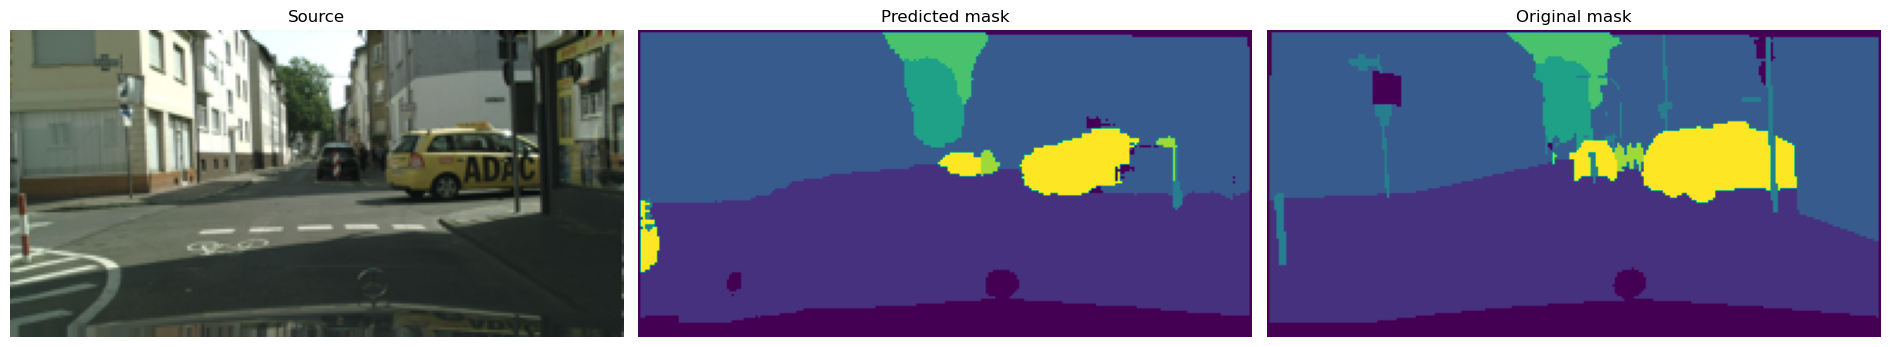

In [54]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [55]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [56]:
scorer.show_scores()

,IoU,Dice,training_time,inference_time_500,inference_time_1
U-Net_baseline,0.552171,0.667224,517.575655,1.851263,0.895139
U-Net_baseline_with_data_augmentation_1,0.564558,0.680571,1029.694759,2.369722,0.423762
U-Net_baseline_with_data_augmentation_2,0.559365,0.674603,714.297488,2.345822,0.924520


## 3.3 Augmentations automatique #1 <a class="anchor" id="data_augmentation_auto_1"></a> [⇪](#menu)

Pour ce troisème essai, nous allons utiliser les transformations calculées sur ce même jeu de données avec [AutoAlbument](#https://albumentations.ai/docs/autoalbument/)

AutoAlbument fonctionnant avec pytorch, j'ai préparé un autre dataloader adapté (dans le dossier autoalbument) et entrainé un Unet sur notre jeu de données pour tenter de trouver les transformations optimales. Ensuite le resultat à été stocké dans un fichier policy.json que nous allons charger et utiliser pour la suite.

### Préparons les training et validation sets **avec** data-augmentation

In [57]:
transformAuto = A.load("autoalbument/policy_28.json")

In [58]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transformAuto,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [59]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [60]:
model_name = "U-Net_baseline_with_data_augmentation_3"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.9609 - iou_score: 0.2984 - f1-score: 0.4178
Epoch 1: val_iou_score improved from -inf to 0.08976, saving model to models/U-Net_baseline_with_data_augmentation_3.keras
372/372 [==============================] - 30s 76ms/step - loss: 0.9609 - iou_score: 0.2984 - f1-score: 0.4178 - val_loss: 1.8713 - val_iou_score: 0.0898 - val_f1-score: 0.1558 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.7015 - iou_score: 0.3596 - f1-score: 0.4848
Epoch 2: val_iou_score did not improve from 0.08976
372/372 [==============================] - 28s 75ms/step - loss: 0.7015 - iou_score: 0.3596 - f1-score: 0.4848 - val_loss: 59.7512 - val_iou_score: 0.0636 - val_f1-score: 0.1134 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.6438 - iou_score: 0.3841 - f1-score: 0.5105
Epoch 3: val_iou_score improved from 0.08976 to 0.10729, saving model to models/U-Net

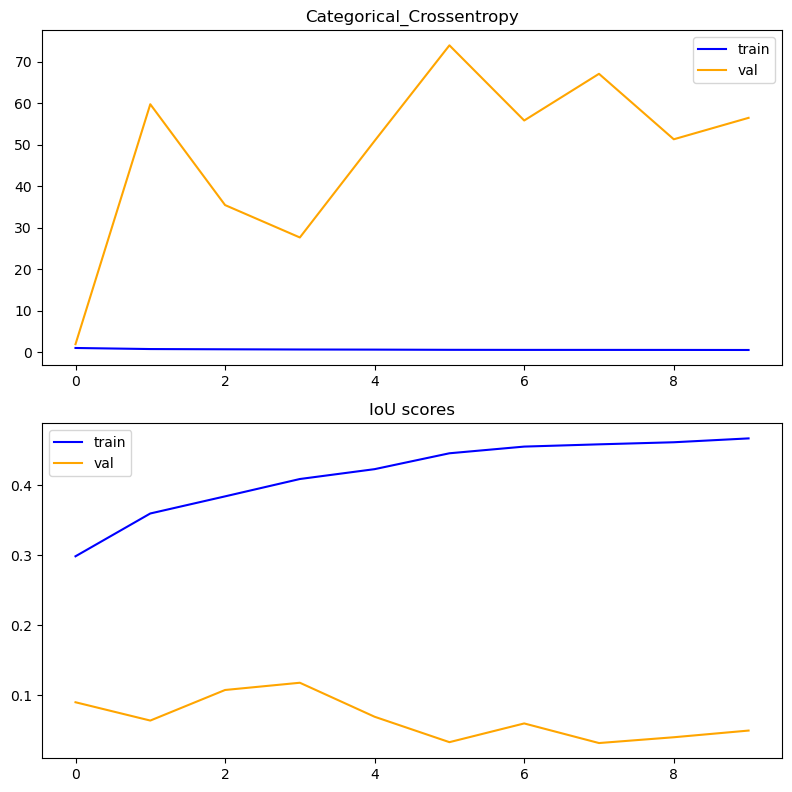

In [61]:
summarize_diagnostics(history)

In [62]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [63]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 26ms/step - loss: 27.6132 - iou_score: 0.1178 - f1-score: 0.1973
inference time (500 samples): 2.19s


### Test de prédiction

In [64]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [65]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 389ms/step
Inference time: 0.41s


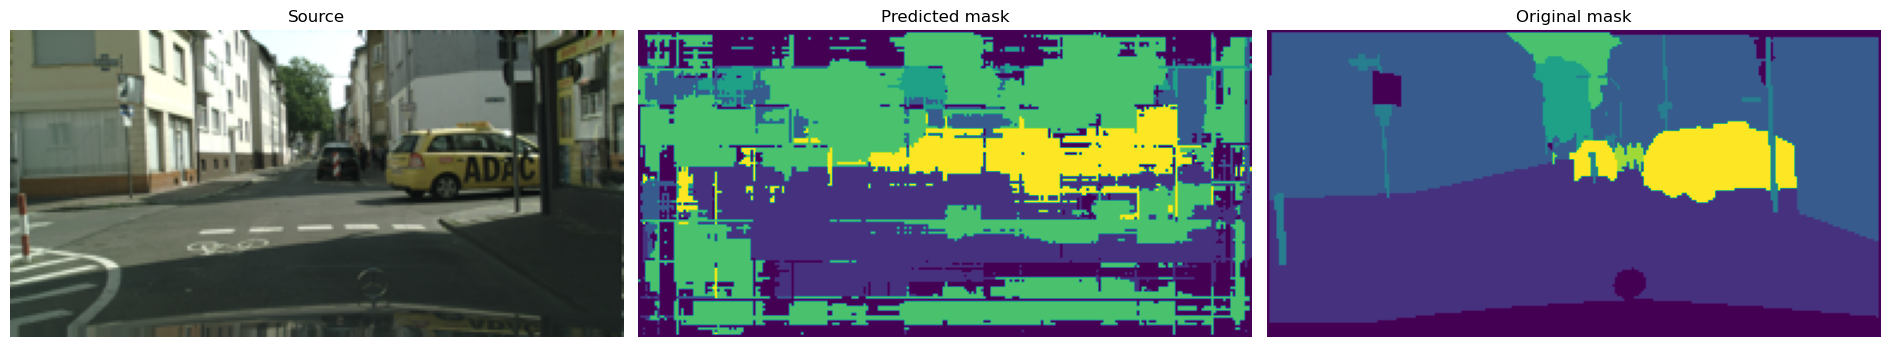

In [66]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [67]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [68]:
scorer.show_scores()

,IoU,Dice,training_time,inference_time_500,inference_time_1
U-Net_baseline,0.552171,0.667224,517.575655,1.851263,0.895139
U-Net_baseline_with_data_augmentation_1,0.564558,0.680571,1029.694759,2.369722,0.423762
U-Net_baseline_with_data_augmentation_2,0.559365,0.674603,714.297488,2.345822,0.924520
U-Net_baseline_with_data_augmentation_3,0.117844,0.197346,284.685457,2.193978,0.414083


> ### Conclusion
> A ce stade, le meilleur modèle semble être `U-Net_baseline_with_data_augmentation_1` qui surpasse le modèle de référence `U-Net_baseline` et les autres.
>
> Mais `U-Net_baseline_with_data_augmentation_2` obtient également une légère augmentation tout en gardant un temps de training plus bas.... on va donc utiliser cette seconde approche pour minimiser nos coûts d'entrainement...
>
> On note également la contre performance du modèle dont les transformations ont été calculées avec `AutoAlbument`

---
---
# 4. Recherche d'une meilleure fonction de perte <a class="anchor" id="loss"></a> [⇪](#menu)

## 4.1 Utilisation de Dice comme fonction de perte <a class="anchor" id="loss_dice"></a> [⇪](#menu)

### Préparons les training et validation sets **avec** data-augmentation

In [21]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [37]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [27]:
model_name = "U-Net_baseline_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.4331 - iou_score: 0.4484 - f1-score: 0.5669
Epoch 1: val_iou_score improved from -inf to 0.12267, saving model to models/U-Net_baseline_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 32s 86ms/step - loss: 0.4331 - iou_score: 0.4484 - f1-score: 0.5669 - val_loss: 0.8203 - val_iou_score: 0.1227 - val_f1-score: 0.1796 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.3539 - iou_score: 0.5255 - f1-score: 0.6461
Epoch 2: val_iou_score improved from 0.12267 to 0.48494, saving model to models/U-Net_baseline_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 29s 77ms/step - loss: 0.3539 - iou_score: 0.5255 - f1-score: 0.6461 - val_loss: 0.3963 - val_iou_score: 0.4849 - val_f1-score: 0.6038 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.3346 - iou_score: 0.5453 - f1-score: 0

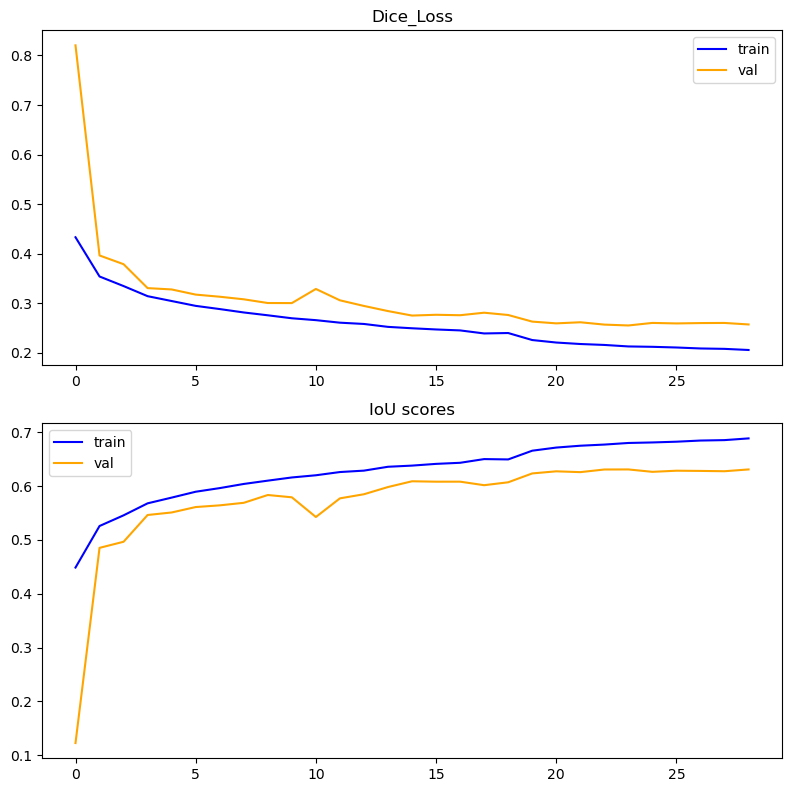

In [28]:
summarize_diagnostics(history)

In [30]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [31]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 25ms/step - loss: 0.2559 - iou_score: 0.6317 - f1-score: 0.7440
inference time (500 samples): 2.14s


### Test de prédiction

In [32]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [33]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 873ms/step
Inference time: 0.90s


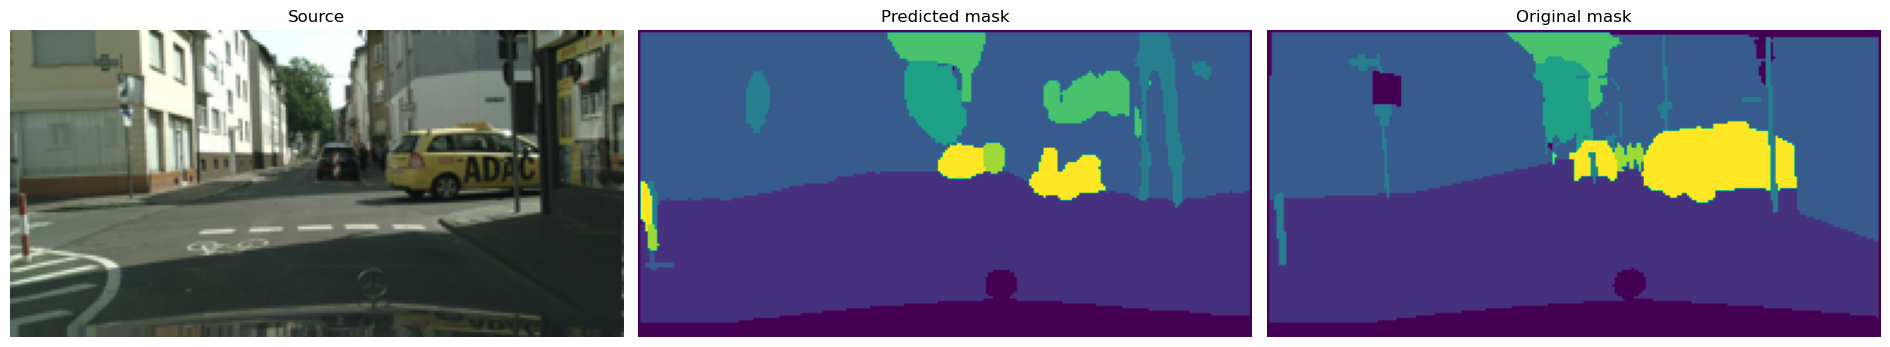

In [34]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [35]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [40]:
scorer.show_scores()

,IoU,Dice,training_time,inference_time_500,inference_time_1
U-Net_baseline,0.552171,0.667224,517.575655,1.851263,0.895139
U-Net_baseline_with_data_augmentation_1,0.564558,0.680571,1029.694759,2.369722,0.423762
U-Net_baseline_with_data_augmentation_2,0.559365,0.674603,714.297488,2.345822,0.924520
U-Net_baseline_with_data_augmentation_3,0.117844,0.197346,284.685457,2.193978,0.414083
U-Net_baseline_with_data_augmentation_2_diceLoss,0.631681,0.743959,843.582155,2.138717,0.903396


----
----
----

# Modèle autre

In [22]:
# From "Deep Learning with Python 2nd edition" page 244
def get_model3(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Conv2D(64,  3, activation="relu", padding="same", strides=2)(inputs)
    x = layers.Conv2D(64,  3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64,  3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64,  3, activation='relu', padding='same', strides=2)(x)
    
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [70]:
# U-Net mini https://github.com/YBIGTA/DL_Models/blob/master/models/unet/Keras%20(on%20Google%20Colaboratory)/mini%20u-net.ipynb
def get_model_mini(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    conv1_1 = layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_1')(inputs)
    conv1_2 = layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_2')(conv1_1)
    pool_1 = layers.MaxPooling2D(name = 'pool_1')(conv1_2)
    
    conv2_1 = layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_1')(pool_1)
    conv2_2 = layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_2')(conv2_1)
    pool_2 = layers.MaxPooling2D(name = 'pool_2')(conv2_2)

    conv3_1 = layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_1')(pool_2)
    conv3_2 = layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_2')(conv3_1)
    pool_3 = layers.MaxPooling2D(name = 'pool_3')(conv3_2)
    
    conv4_1 = layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_1')(pool_3)
    conv4_2 = layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_2')(conv4_1)
    
    # Expanding Path
    upconv5_1 = layers.UpSampling2D(name = 'upconv5_1')(conv4_2)
    upconv5_2 = layers.Conv2D(filters = 128, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv5_2')(upconv5_1)
    
    concat_5 = layers.concatenate([upconv5_2, conv3_2], axis = 3, name = 'concat_5')
    conv5_1 = layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_1')(concat_5)
    conv5_2 = layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_2')(conv5_1)
    
    upconv6_1 = layers.UpSampling2D(name = 'upconv6_1')(conv5_2)
    upconv6_2 = layers.Conv2D(filters = 64, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv6_2')(upconv6_1)
    concat_6 = layers.concatenate([upconv6_2, conv2_2], axis = 3, name = 'concat_6')
    
    conv6_1 = layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_1')(concat_6)
    conv6_2 = layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_2')(conv6_1)
    
    upconv7_1 = layers.UpSampling2D(name = 'upconv7_1')(conv6_2)
    upconv7_2 = layers.Conv2D(filters = 32, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv7_2')(upconv7_1)
    concat_7 = layers.concatenate([upconv7_2, conv1_2], axis = 3, name = 'concat_7')
    
    conv7_1 = layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_1')(concat_7)
    conv7_2 = layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_2')(conv7_1)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(conv7_2)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

### Définissons un pré-processing

In [ ]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Définissons et entrainons un modèle

In [ ]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# f_loss = sm.losses.bce_jaccard_loss
f_metrics = [sm.metrics.iou_score]

model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss, # sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)